In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import os.path

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf

from sklearn.metrics import accuracy_score, f1_score

print(f'tensorflow version is {tf.__version__}')

tensorflow version is 2.15.0


In [ ]:
def imgPaths(filepath):

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop = True)

    return df

In [ ]:
!cp "/content/drive/MyDrive/sign/TRAIN.zip" /content/

cp: cannot stat '/content/drive/MyDrive/sign/TRAIN.zip': No such file or directory


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/TRAIN.zip

unzip:  cannot find or open /content/TRAIN.zip, /content/TRAIN.zip.zip or /content/TRAIN.zip.ZIP.


In [ ]:
# Create Variables
train_image_dir = Path('/content/TRAIN/asl_alphabet_train/asl_alphabet_train')
train_filepaths = list(train_image_dir.glob(r'**/*.jpg'))

test_image_dir = Path('/content/TRAIN/asl_alphabet_test')
test_filepaths = list(train_image_dir.glob(r'**/*.jpg'))

# Create df
train_df = imgPaths(train_filepaths)
test_df = imgPaths(test_filepaths)

# Show the result
print(train_df.head(3))
print(test_df.head(3))

Empty DataFrame
Columns: [Filepath, Label]
Index: []
Empty DataFrame
Columns: [Filepath, Label]
Index: []


<ipython-input-2-58d6532b0ce2>:6: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  filepath = pd.Series(filepath, name='Filepath').astype(str)
<ipython-input-2-58d6532b0ce2>:7: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  labels = pd.Series(labels, name='Label')
<ipython-input-2-58d6532b0ce2>:6: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  filepath = pd.Series(filepath, name='Filepath').astype(str)
<ipython-input-2-58d6532b0ce2>:7: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  labels = pd.Series(labels, name='Label')


In [ ]:
print(f'Number of pictures: {train_df.shape[0]}\n')

print(f'Number of different labels: {len(train_df.Label.unique())}\n')

print(f'Labels: {train_df.Label.unique()}')


# Create a DataFrame with one Label of each category
# drops dups of columns
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()

Number of pictures: 87000

Number of different labels: 29

Labels: ['nothing' 'Z' 'D' 'C' 'X' 'J' 'L' 'E' 'B' 'P' 'U' 'S' 'G' 'V' 'O' 'space'
 'T' 'K' 'del' 'R' 'M' 'N' 'A' 'Y' 'F' 'W' 'I' 'Q' 'H']


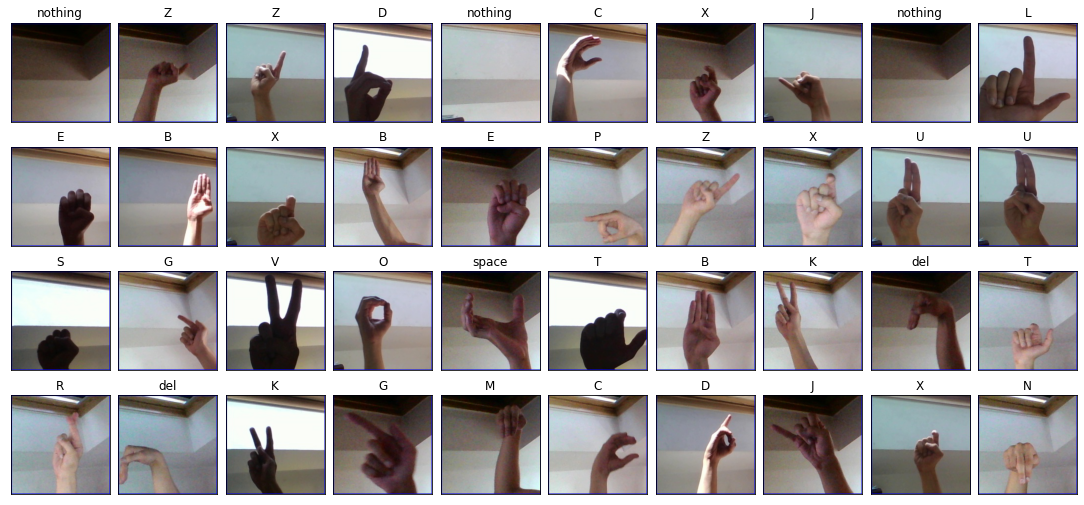

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(train_df.Filepath[i]))
    ax.set_title(train_df.Label[i])
plt.tight_layout(pad=.5)
plt.show()

In [ ]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [ ]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(244, 244),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 69600 validated image filenames belonging to 29 classes.
Found 17400 validated image filenames belonging to 29 classes.
Found 87000 validated image filenames belonging to 29 classes.


In [ ]:
pretrainedModel = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
     include_top=False,
     weights='imagenet',
     pooling='avg'
)
pretrainedModel.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
inputs = pretrainedModel.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrainedModel.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(29, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

adam = tf.keras.optimizers.Adam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam'

)

model.compile(
    optimizer=adam,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=3,
    callbacks=[
         tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
     ]
 )

Epoch 1/3
2175/2175 [==============================] - 190s 86ms/step - loss: 0.2137 - accuracy: 0.9380 - val_loss: 0.1532 - val_accuracy: 0.9493
Epoch 2/3
2175/2175 [==============================] - 184s 85ms/step - loss: 0.0498 - accuracy: 0.9830 - val_loss: 0.2525 - val_accuracy: 0.9211
Epoch 3/3
2175/2175 [==============================] - 182s 84ms/step - loss: 0.0385 - accuracy: 0.9870 - val_loss: 0.0824 - val_accuracy: 0.9741


In [ ]:
from tensorflow.keras.models import model_from_json
model1_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model1_json)
# serialize weights to HDF5
model.save("model.h5")
print("Saved model to disk")


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Saved model to disk


In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
____________________________________________________________________________________________

In [ ]:
from tensorflow.keras.models import load_model
model=load_model("/content/model1.h5")
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.09686
Test Accuracy: 96.64%


In [ ]:
pred = model.predict(test_images)
print("pred",pred)
pred = np.argmax(pred,axis=1)
print("predmax", pred)

# Map the label
labels = (train_images.class_indices)
print(labels)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]
print(pred)

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

pred [[6.9340537e-08 7.4512812e-08 1.4720342e-09 ... 1.6147260e-12
  7.5699351e-12 1.3144223e-11]
 [9.9967587e-01 9.8017185e-09 2.4894952e-13 ... 3.0787705e-16
  3.3905212e-11 3.7959542e-13]
 [1.6130626e-08 1.7921158e-05 5.2802788e-12 ... 4.3106310e-09
  9.9986911e-01 1.4392887e-09]
 ...
 [4.1002403e-11 2.2123915e-10 1.0439497e-07 ... 1.3016521e-05
  3.5534796e-08 2.9333296e-07]
 [6.0931221e-12 5.5778066e-11 5.6699674e-15 ... 1.7403761e-12
  1.9973085e-19 2.0616736e-11]
 [7.3962802e-08 2.8152924e-10 9.4716324e-06 ... 6.9549237e-08
  2.1077774e-13 3.9354182e-07]]
predmax [22  0 27 ... 15 10  6]
{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25, 'del': 26, 'nothing': 27, 'space': 28}
['W', 'A', 'nothing', 'V', 'S', 'J', 'W', 'D', 'B', 'V', 'P', 'L', 'R', 'D', 'S', 'L', 'R', 'M', 'P', 'V', 'S', 'R', 'G', 'del', 'B', '

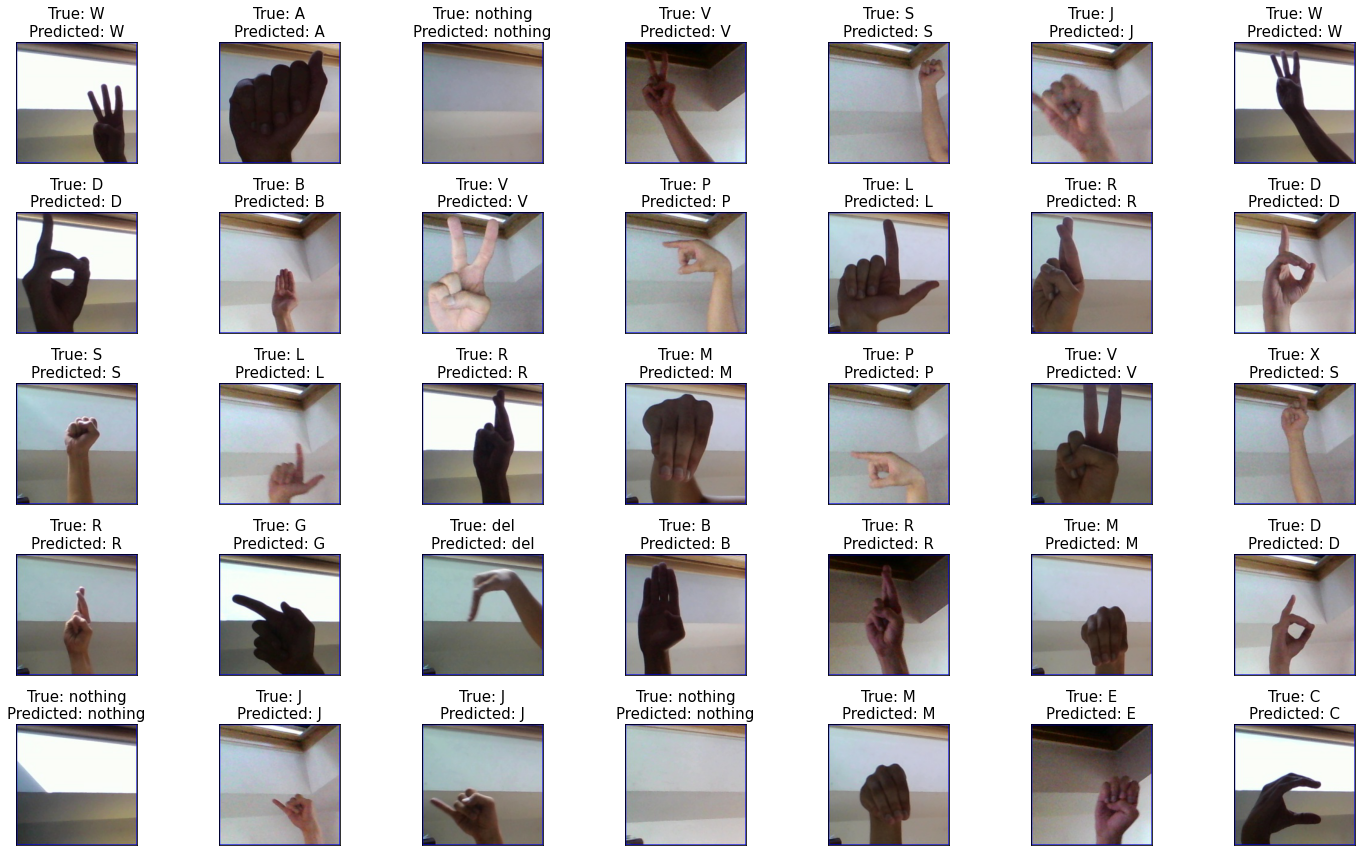

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=7, figsize=(20, 12),
                        subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i].split('_')[0]}\nPredicted: {pred[i].split('_')[0]}", fontsize = 15)
plt.tight_layout()
plt.show()